In [146]:
from pathlib import Path

import numpy as np
import pandas as pd
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split


In [147]:
DATA_PATH = Path.cwd().parent / "Prabhanu Gunaweera"/"Downloads"/"ML_Project"

In [148]:
training_df = pd.read_csv(
    DATA_PATH / "training_set_values.csv",
    index_col = "id"
)
training_lbls = pd.read_csv(
    DATA_PATH / "training_set_lables.csv",
    index_col = "id"
)

In [149]:
training_df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Handling Missing Values

In [150]:
training_df['gps_height'].replace(0.0, np.nan, inplace=True)
training_df['population'].replace(0.0, np.nan, inplace=True)
training_df['amount_tsh'].replace(0.0, np.nan, inplace=True)

training_df["gps_height"].fillna(training_df.groupby(['region', 'district_code'])["gps_height"].transform("mean"), inplace=True)
training_df["gps_height"].fillna(training_df.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
training_df["gps_height"].fillna(training_df["gps_height"].mean(), inplace=True)

training_df["population"].fillna(training_df.groupby(['region', 'district_code'])["population"].transform("median"), inplace=True)
training_df["population"].fillna(training_df.groupby(['region'])["population"].transform("median"), inplace=True)
training_df["population"].fillna(training_df["population"].median(), inplace=True)

training_df["amount_tsh"].fillna(training_df.groupby(['region', 'district_code'])["amount_tsh"].transform("median"), inplace=True)
training_df["amount_tsh"].fillna(training_df.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
training_df["amount_tsh"].fillna(training_df["amount_tsh"].median(), inplace=True)

In [151]:
training_df['longitude'].replace(0.0, np.nan, inplace=True)
training_df['latitude'].replace(0.0, np.nan, inplace=True)

training_df["latitude"].fillna(training_df.groupby(['region', 'district_code'])["latitude"].transform("mean"), inplace=True)
training_df["latitude"].fillna(training_df.groupby(['region'])["latitude"].transform("mean"), inplace=True)

training_df["longitude"].fillna(training_df.groupby(['region', 'district_code'])["longitude"].transform("mean"), inplace=True)
training_df["longitude"].fillna(training_df.groupby(['region'])["longitude"].transform("mean"), inplace=True)

In [152]:
training_df.drop(['scheme_name','construction_year','num_private','subvillage','recorded_by','region_code'], axis=1, inplace=True)

In [153]:
training_df.permit.fillna(True,inplace = True)

In [154]:
training_df.installer.fillna("DWE",inplace = True)

In [155]:
training_df.public_meeting.fillna(True,inplace = True)

In [156]:
training_df.scheme_management.fillna("VWC",inplace = True)

In [157]:
training_lbls.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [158]:
print("data",training_df.shape)
print("lables",training_lbls.shape)

data (59400, 33)
lables (59400, 1)


In [159]:
df = training_df.join(training_lbls)

In [160]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,region,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390.000000,Roman,34.938093,-9.856322,none,Lake Nyasa,Iringa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,200.0,2013-03-06,Grumeti,1399.000000,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Mara,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686.000000,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Manyara,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,50.0,2013-01-28,Unicef,263.000000,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mtwara,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,250.0,2011-07-13,Action In A,1057.545585,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kagera,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [161]:
high = df.loc[df.gps_height > 2000]["status_group"]
high.value_counts()

functional                 1014
non functional              178
functional needs repair      30
Name: status_group, dtype: int64

# Feature Selection

In [162]:
training_df["date_recorded_month"] = training_df['date_recorded'].str.split('-').str[1]
training_df["date_recorded_year"] = training_df['date_recorded'].str.split('-').str[0]
training_df.drop(['date_recorded'], axis=1, inplace=True)

In [163]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_df, training_lbls, test_size=0.2)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(47520, 34) (47520, 1)
(11880, 34) (11880, 1)


In [164]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe

In [165]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

In [166]:
cat_cols = X_train.select_dtypes('object').columns

In [167]:
ct = ColumnTransformer(
    [('ordinal', oe(), cat_cols)],
    remainder='passthrough')

In [168]:
all_cols = X_train.columns

In [169]:
sfs = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=5)

In [170]:
sfs = sfs.fit(ct.fit_transform(X_train), np.array(y_train.status_group).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  3.9min finished

[2021-09-17 22:49:29] Features: 1/34 -- score: 0.6474747474747475[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  4.5min finished

[2021-09-17 22:54:02] Features: 2/34 -- score: 0.6984006734006735[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  5.1min finished

[2021-09-17 22:59:05] Features: 3/34 -- score: 0.7338594276094276[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min finished

[2021-09-18 00:33:57] Features: 28/34 -- score: 0.78253367003367[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min finished

[2021-09-18 00:35:16] Features: 29/34 -- score: 0.780702861952862[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished

[2021-09-18 00:36:23] Features: 30/34 -- score: 0.7819234006734007[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.1s finished

[2021-09-18 00:37:15] Features: 31/34 

In [171]:
sfdf = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfdf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(17,)","[0.6508838383838383, 0.6468855218855218, 0.646...",0.647475,"(17,)",0.002581,0.002008,0.001004
2,"(17, 22)","[0.7035984848484849, 0.7026515151515151, 0.692...",0.698401,"(17, 22)",0.005353,0.004165,0.002082
3,"(5, 17, 22)","[0.7387415824915825, 0.7346380471380471, 0.733...",0.733859,"(5, 17, 22)",0.003687,0.002869,0.001434
4,"(5, 17, 22, 28)","[0.7468434343434344, 0.7490530303030303, 0.743...",0.744971,"(5, 17, 22, 28)",0.004117,0.003203,0.001602
5,"(5, 8, 17, 22, 28)","[0.7553661616161617, 0.7564183501683501, 0.752...",0.752567,"(5, 8, 17, 22, 28)",0.003893,0.003029,0.001514
6,"(5, 8, 13, 17, 22, 28)","[0.7691498316498316, 0.7625210437710438, 0.760...",0.760711,"(5, 8, 13, 17, 22, 28)",0.006372,0.004957,0.002479
7,"(5, 8, 13, 17, 22, 28, 29)","[0.7727272727272727, 0.7672558922558923, 0.767...",0.765404,"(5, 8, 13, 17, 22, 28, 29)",0.006551,0.005097,0.002549
8,"(0, 5, 8, 13, 17, 22, 28, 29)","[0.7748316498316499, 0.7686237373737373, 0.771...",0.76976,"(0, 5, 8, 13, 17, 22, 28, 29)",0.003951,0.003074,0.001537
9,"(0, 5, 8, 11, 13, 17, 22, 28, 29)","[0.782723063973064, 0.7749368686868687, 0.7719...",0.773885,"(0, 5, 8, 11, 13, 17, 22, 28, 29)",0.006161,0.004793,0.002397
10,"(0, 5, 8, 11, 13, 17, 22, 28, 29, 31)","[0.779145622895623, 0.7731481481481481, 0.7753...",0.773758,"(0, 5, 8, 11, 13, 17, 22, 28, 29, 31)",0.004174,0.003247,0.001624


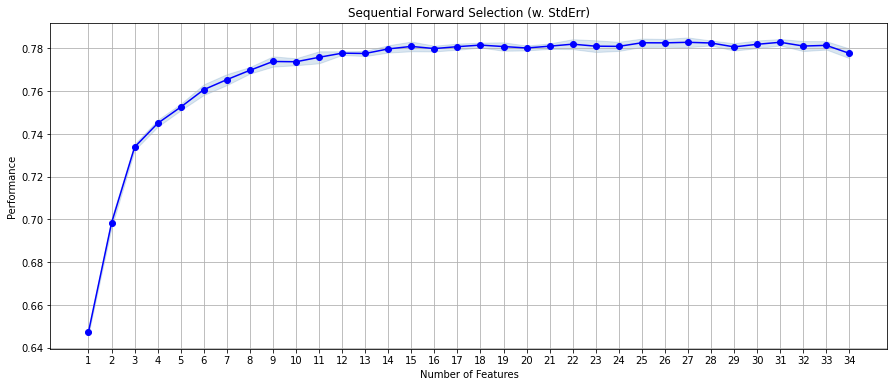

In [172]:
from matplotlib import pyplot as plt

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [173]:
print(sfdf.loc[30, 'feature_idx'])

(0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33)


In [174]:
selected_columns = [all_cols[i] for i in 
                      list((0, 1, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31))]

In [175]:
selected_columns

['amount_tsh',
 'funder',
 'longitude',
 'latitude',
 'wpt_name',
 'basin',
 'district_code',
 'lga',
 'population',
 'public_meeting',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management_group',
 'payment',
 'payment_type',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [176]:
drop_list = ['funder', 'gps_height', 'basin',
       'lga',  'public_meeting', 'scheme_management',
       'extraction_type_class', 'management', 'management_group', 
       'payment_type', 'waterpoint_type_group']

In [177]:
X_train.drop(drop_list, axis=1, inplace=True)

c:\users\prabhanu gunaweera\myenv\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [178]:
X_test.drop(drop_list, axis=1, inplace=True)

# Model

In [179]:
cat_features = list(X_train.select_dtypes('object').columns)
cat_features

['installer',
 'wpt_name',
 'region',
 'ward',
 'extraction_type',
 'extraction_type_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'date_recorded_month',
 'date_recorded_year']

In [180]:
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

In [181]:
eval_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=cat_features)

In [182]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=5,
                           loss_function='MultiClass')

In [183]:
model.fit(train_dataset)

0:	learn: 1.0251416	total: 207ms	remaining: 3m 26s
1:	learn: 0.9683743	total: 431ms	remaining: 3m 35s
2:	learn: 0.9215749	total: 653ms	remaining: 3m 37s
3:	learn: 0.8831627	total: 858ms	remaining: 3m 33s
4:	learn: 0.8458673	total: 1.06s	remaining: 3m 30s
5:	learn: 0.8143936	total: 1.29s	remaining: 3m 33s
6:	learn: 0.7896031	total: 1.52s	remaining: 3m 35s
7:	learn: 0.7666448	total: 1.73s	remaining: 3m 34s
8:	learn: 0.7470078	total: 1.91s	remaining: 3m 30s
9:	learn: 0.7305844	total: 2.13s	remaining: 3m 31s
10:	learn: 0.7157144	total: 2.38s	remaining: 3m 34s
11:	learn: 0.7000618	total: 2.6s	remaining: 3m 34s
12:	learn: 0.6881830	total: 2.88s	remaining: 3m 38s
13:	learn: 0.6767768	total: 3.1s	remaining: 3m 38s
14:	learn: 0.6681969	total: 3.4s	remaining: 3m 42s
15:	learn: 0.6584324	total: 3.66s	remaining: 3m 45s
16:	learn: 0.6514565	total: 3.91s	remaining: 3m 45s
17:	learn: 0.6449145	total: 4.15s	remaining: 3m 46s
18:	learn: 0.6369879	total: 4.35s	remaining: 3m 44s
19:	learn: 0.6302466	tota

159:	learn: 0.5309529	total: 44.2s	remaining: 3m 52s
160:	learn: 0.5304320	total: 44.4s	remaining: 3m 51s
161:	learn: 0.5302619	total: 44.7s	remaining: 3m 51s
162:	learn: 0.5299077	total: 44.9s	remaining: 3m 50s
163:	learn: 0.5297924	total: 45.1s	remaining: 3m 49s
164:	learn: 0.5297223	total: 45.3s	remaining: 3m 49s
165:	learn: 0.5294884	total: 45.6s	remaining: 3m 49s
166:	learn: 0.5293833	total: 46s	remaining: 3m 49s
167:	learn: 0.5292633	total: 46.4s	remaining: 3m 49s
168:	learn: 0.5291546	total: 46.8s	remaining: 3m 49s
169:	learn: 0.5290145	total: 47.3s	remaining: 3m 50s
170:	learn: 0.5288929	total: 47.8s	remaining: 3m 51s
171:	learn: 0.5288046	total: 48.2s	remaining: 3m 51s
172:	learn: 0.5287416	total: 48.8s	remaining: 3m 53s
173:	learn: 0.5285007	total: 49.3s	remaining: 3m 54s
174:	learn: 0.5283443	total: 49.8s	remaining: 3m 54s
175:	learn: 0.5282924	total: 50.3s	remaining: 3m 55s
176:	learn: 0.5281431	total: 50.7s	remaining: 3m 55s
177:	learn: 0.5280205	total: 51.1s	remaining: 3m

313:	learn: 0.5143916	total: 1m 27s	remaining: 3m 11s
314:	learn: 0.5143662	total: 1m 27s	remaining: 3m 10s
315:	learn: 0.5143170	total: 1m 28s	remaining: 3m 10s
316:	learn: 0.5142543	total: 1m 28s	remaining: 3m 10s
317:	learn: 0.5142345	total: 1m 28s	remaining: 3m 9s
318:	learn: 0.5141069	total: 1m 28s	remaining: 3m 9s
319:	learn: 0.5140884	total: 1m 29s	remaining: 3m 9s
320:	learn: 0.5140434	total: 1m 29s	remaining: 3m 8s
321:	learn: 0.5140138	total: 1m 29s	remaining: 3m 8s
322:	learn: 0.5138409	total: 1m 29s	remaining: 3m 7s
323:	learn: 0.5136135	total: 1m 29s	remaining: 3m 7s
324:	learn: 0.5135513	total: 1m 30s	remaining: 3m 7s
325:	learn: 0.5135075	total: 1m 30s	remaining: 3m 6s
326:	learn: 0.5134551	total: 1m 30s	remaining: 3m 6s
327:	learn: 0.5134265	total: 1m 30s	remaining: 3m 5s
328:	learn: 0.5134095	total: 1m 30s	remaining: 3m 5s
329:	learn: 0.5133499	total: 1m 31s	remaining: 3m 5s
330:	learn: 0.5132875	total: 1m 31s	remaining: 3m 4s
331:	learn: 0.5132041	total: 1m 31s	remain

469:	learn: 0.5029939	total: 2m 10s	remaining: 2m 27s
470:	learn: 0.5029556	total: 2m 10s	remaining: 2m 26s
471:	learn: 0.5029257	total: 2m 11s	remaining: 2m 26s
472:	learn: 0.5028761	total: 2m 11s	remaining: 2m 26s
473:	learn: 0.5028288	total: 2m 11s	remaining: 2m 25s
474:	learn: 0.5027784	total: 2m 11s	remaining: 2m 25s
475:	learn: 0.5026567	total: 2m 11s	remaining: 2m 25s
476:	learn: 0.5025274	total: 2m 12s	remaining: 2m 24s
477:	learn: 0.5025033	total: 2m 12s	remaining: 2m 24s
478:	learn: 0.5024066	total: 2m 12s	remaining: 2m 24s
479:	learn: 0.5023044	total: 2m 12s	remaining: 2m 23s
480:	learn: 0.5022569	total: 2m 13s	remaining: 2m 23s
481:	learn: 0.5022303	total: 2m 13s	remaining: 2m 23s
482:	learn: 0.5021695	total: 2m 13s	remaining: 2m 22s
483:	learn: 0.5021098	total: 2m 13s	remaining: 2m 22s
484:	learn: 0.5020890	total: 2m 13s	remaining: 2m 22s
485:	learn: 0.5020045	total: 2m 14s	remaining: 2m 21s
486:	learn: 0.5019641	total: 2m 14s	remaining: 2m 21s
487:	learn: 0.5019508	total:

622:	learn: 0.4943677	total: 2m 51s	remaining: 1m 44s
623:	learn: 0.4943292	total: 2m 52s	remaining: 1m 43s
624:	learn: 0.4942713	total: 2m 52s	remaining: 1m 43s
625:	learn: 0.4941969	total: 2m 53s	remaining: 1m 43s
626:	learn: 0.4941153	total: 2m 53s	remaining: 1m 43s
627:	learn: 0.4939898	total: 2m 54s	remaining: 1m 43s
628:	learn: 0.4939378	total: 2m 54s	remaining: 1m 42s
629:	learn: 0.4938888	total: 2m 54s	remaining: 1m 42s
630:	learn: 0.4938211	total: 2m 55s	remaining: 1m 42s
631:	learn: 0.4937529	total: 2m 55s	remaining: 1m 42s
632:	learn: 0.4937114	total: 2m 55s	remaining: 1m 41s
633:	learn: 0.4936701	total: 2m 55s	remaining: 1m 41s
634:	learn: 0.4936182	total: 2m 55s	remaining: 1m 41s
635:	learn: 0.4935185	total: 2m 56s	remaining: 1m 40s
636:	learn: 0.4934848	total: 2m 56s	remaining: 1m 40s
637:	learn: 0.4934617	total: 2m 56s	remaining: 1m 40s
638:	learn: 0.4934432	total: 2m 56s	remaining: 1m 39s
639:	learn: 0.4933217	total: 2m 56s	remaining: 1m 39s
640:	learn: 0.4932960	total:

776:	learn: 0.4855355	total: 3m 33s	remaining: 1m 1s
777:	learn: 0.4854774	total: 3m 34s	remaining: 1m 1s
778:	learn: 0.4854177	total: 3m 34s	remaining: 1m
779:	learn: 0.4853995	total: 3m 35s	remaining: 1m
780:	learn: 0.4853948	total: 3m 35s	remaining: 1m
781:	learn: 0.4853436	total: 3m 35s	remaining: 1m
782:	learn: 0.4853199	total: 3m 36s	remaining: 59.9s
783:	learn: 0.4852887	total: 3m 36s	remaining: 59.7s
784:	learn: 0.4852519	total: 3m 36s	remaining: 59.4s
785:	learn: 0.4852298	total: 3m 36s	remaining: 59.1s
786:	learn: 0.4851627	total: 3m 37s	remaining: 58.8s
787:	learn: 0.4851185	total: 3m 37s	remaining: 58.5s
788:	learn: 0.4850440	total: 3m 37s	remaining: 58.2s
789:	learn: 0.4850277	total: 3m 37s	remaining: 57.9s
790:	learn: 0.4849868	total: 3m 38s	remaining: 57.6s
791:	learn: 0.4849539	total: 3m 38s	remaining: 57.4s
792:	learn: 0.4849335	total: 3m 38s	remaining: 57.1s
793:	learn: 0.4848378	total: 3m 38s	remaining: 56.8s
794:	learn: 0.4848078	total: 3m 39s	remaining: 56.5s
795:	

932:	learn: 0.4777809	total: 4m 18s	remaining: 18.5s
933:	learn: 0.4777372	total: 4m 18s	remaining: 18.2s
934:	learn: 0.4777125	total: 4m 18s	remaining: 18s
935:	learn: 0.4776654	total: 4m 18s	remaining: 17.7s
936:	learn: 0.4776254	total: 4m 18s	remaining: 17.4s
937:	learn: 0.4775853	total: 4m 19s	remaining: 17.1s
938:	learn: 0.4775383	total: 4m 19s	remaining: 16.8s
939:	learn: 0.4774598	total: 4m 19s	remaining: 16.6s
940:	learn: 0.4773773	total: 4m 19s	remaining: 16.3s
941:	learn: 0.4773426	total: 4m 20s	remaining: 16s
942:	learn: 0.4772903	total: 4m 20s	remaining: 15.7s
943:	learn: 0.4772465	total: 4m 20s	remaining: 15.5s
944:	learn: 0.4771861	total: 4m 20s	remaining: 15.2s
945:	learn: 0.4771483	total: 4m 20s	remaining: 14.9s
946:	learn: 0.4771270	total: 4m 21s	remaining: 14.6s
947:	learn: 0.4770716	total: 4m 21s	remaining: 14.3s
948:	learn: 0.4770455	total: 4m 21s	remaining: 14.1s
949:	learn: 0.4770101	total: 4m 21s	remaining: 13.8s
950:	learn: 0.4769807	total: 4m 22s	remaining: 13.

In [184]:
preds_class = model.predict(eval_dataset)

In [185]:
preds_class

array([['functional'],
       ['non functional'],
       ['non functional'],
       ...,
       ['functional'],
       ['functional'],
       ['functional']], dtype=object)

In [186]:
preds_proba = model.predict_proba(eval_dataset)

In [187]:
preds_proba

array([[9.59554407e-01, 2.73291313e-02, 1.31164621e-02],
       [3.00087657e-03, 4.36901968e-04, 9.96562221e-01],
       [4.75920843e-02, 1.05842091e-02, 9.41823707e-01],
       ...,
       [7.38794864e-01, 1.01008627e-01, 1.60196509e-01],
       [8.81169559e-01, 2.02884585e-02, 9.85419823e-02],
       [7.39939331e-01, 7.76429871e-02, 1.82417681e-01]])

In [188]:
preds_raw = model.predict(eval_dataset, 
                          prediction_type='RawFormulaVal')

In [189]:
preds_raw

array([[ 2.61703891, -0.94147689, -1.67556202],
       [-1.29281876, -3.21976963,  4.51258839],
       [-0.49394946, -1.99725273,  2.49120219],
       ...,
       [ 1.17281114, -0.81700323, -0.35580791],
       [ 1.98732176, -1.78387613, -0.20344563],
       [ 1.21823872, -1.03620825, -0.18203047]])

In [190]:
pd.DataFrame({'feature_importance': model.get_feature_importance(train_dataset), 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

,feature_importance,feature_names
7,17.409018,ward
16,8.929872,quantity_group
1,7.838959,installer
12,6.431581,payment
20,6.301385,waterpoint_type
15,5.804029,quantity
8,5.163691,population
5,5.081625,region
10,5.047330,extraction_type
2,4.294483,longitude


In [191]:
test = pd.read_csv(DATA_PATH / "test_set_values.csv", 
                               index_col="id")

In [192]:
test.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [193]:
test['gps_height'].replace(0.0, np.nan, inplace=True)
test['population'].replace(0.0, np.nan, inplace=True)
test['amount_tsh'].replace(0.0, np.nan, inplace=True)

test["gps_height"].fillna(test.groupby(['region', 'district_code'])["gps_height"].transform("mean"), inplace=True)
test["gps_height"].fillna(test.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
test["gps_height"].fillna(test["gps_height"].mean(), inplace=True)
test["population"].fillna(test.groupby(['region', 'district_code'])["population"].transform("median"), inplace=True)
test["population"].fillna(test.groupby(['region'])["population"].transform("median"), inplace=True)
test["population"].fillna(test["population"].median(), inplace=True)
test["amount_tsh"].fillna(test.groupby(['region', 'district_code'])["amount_tsh"].transform("median"), inplace=True)
test["amount_tsh"].fillna(test.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
test["amount_tsh"].fillna(test["amount_tsh"].median(), inplace=True)

In [194]:
test['longitude'].replace(0.0, np.nan, inplace=True)
test['latitude'].replace(0.0, np.nan, inplace=True)

test["latitude"].fillna(training_df.groupby(['region', 'district_code'])["latitude"].transform("mean"), inplace=True)
test["latitude"].fillna(training_df.groupby(['region'])["latitude"].transform("mean"), inplace=True)

test["longitude"].fillna(training_df.groupby(['region', 'district_code'])["longitude"].transform("mean"), inplace=True)
test["longitude"].fillna(training_df.groupby(['region'])["longitude"].transform("mean"), inplace=True)

In [195]:
test["funder"].fillna("other", inplace=True)

In [196]:
test.drop(['scheme_name','construction_year','num_private','subvillage','recorded_by','region_code'], axis=1, inplace=True)

In [197]:
test["date_recorded_month"] = test['date_recorded'].str.split('-').str[1]
test["date_recorded_year"] = test['date_recorded'].str.split('-').str[0]
test.drop(['date_recorded'], axis=1, inplace=True)

In [198]:
test.drop(drop_list, axis=1, inplace=True)

In [199]:
test.installer.fillna("DWE",inplace = True)

In [200]:
test.permit.fillna(True,inplace = True)

In [201]:
test_set = Pool(data=test,
                cat_features=cat_features)

In [202]:
res = model.predict(test_set)

In [203]:
len(res)

14850

In [204]:
res[0]

array(['non functional'], dtype=object)

In [205]:
submission_df = pd.read_csv(DATA_PATH / "SubmissionFormat.csv", 
                            index_col="id")

In [206]:
submission_df.head()

,status_group
id,
50785,predicted label
51630,predicted label
17168,predicted label
45559,predicted label
49871,predicted label


In [207]:
submission_df["status_group"] = res

In [208]:
submission_df.to_csv('submission.csv', index=True)